In [1]:
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.layers import CuDNNLSTM as LSTM
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

Using TensorFlow backend.


In [29]:
NUM_SAMPLES = 10000
MAX_VOCABULARY = 20000
MAX_SEQUENCE_LENGTH = 100
LATENT_DIM = 256
EMBEDDING_DIM = 100
BATCH_SIZE = 128

In [30]:
#Download the file from http://www.manythings.org/anki/
encoder_sentences = []
decoder_sentences_input = []
decoder_sentences_target = []
count = 0
lines = []
with open("spa.txt", encoding='utf-8') as f:
    for line in f:
        
        #Choose the first sentences in the file as they are the shortest ones, we do not want the larger ones
        #as to avoid memory issues
        if(count>=NUM_SAMPLES):
            break;
        encoder_sentence, decoder_sentence = line.split("\t");

        decoder_sentence_input = '<sos> ' + decoder_sentence
        decoder_sentence_target = decoder_sentence + ' <eos>'
        
        encoder_sentences.append(encoder_sentence)
        decoder_sentences_input.append(decoder_sentence_input)
        decoder_sentences_target.append(decoder_sentence_target)
        
        count += 1

In [31]:
#Do not filter ? ! that are common expressions in english.
encoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY, filters = '')
encoder_tokenizer.fit_on_texts(encoder_sentences)

#Do not filter ¿? !¡ that are common expressions in spanish. Only filter new line.
decoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY, filters = '\n')
decoder_tokenizer.fit_on_texts(decoder_sentences_input + decoder_sentences_target)

In [32]:
encoder_sequences = encoder_tokenizer.texts_to_sequences(encoder_sentences)
decoder_sequences_input = decoder_tokenizer.texts_to_sequences(decoder_sentences_input)
decoder_sequences_target = decoder_tokenizer.texts_to_sequences(decoder_sentences_target)

In [33]:
decoder_index2word = {idx: word for word, idx in decoder_tokenizer.word_index.items()}


In [34]:
max_encoder_length = np.max([len(sentence) for sentence in encoder_sequences])
max_decoder_length = np.max([len(sentence) for sentence in decoder_sequences_input])

#Lets choose the minimum of these to save memory
MAX_DECODER_LENGTH = min(MAX_SEQUENCE_LENGTH, max_decoder_length)
MAX_ENCODER_LENGTH = min(MAX_SEQUENCE_LENGTH, max_encoder_length)
#We add one to the max_spanish and english words. This is because indexing with tokenizer starts at 1.
MAX_DECODER_WORDS = min(MAX_VOCABULARY, len(decoder_tokenizer.word_index) + 1) 
MAX_ENCODER_WORDS = min(MAX_VOCABULARY, len(encoder_tokenizer.word_index) + 1)

In [35]:
#Use post padding as we need the <sos> at the beggining of the sentences in the decoder (not necessary to do so in the encoder)
encoder_sequences_padded = pad_sequences(encoder_sequences, maxlen = MAX_ENCODER_LENGTH, padding='post')
decoder_sequences_input_padded = pad_sequences(decoder_sequences_input, maxlen = MAX_DECODER_LENGTH, padding = "post")
decoder_sequences_target_padded = pad_sequences(decoder_sequences_target, maxlen = MAX_DECODER_LENGTH, padding = "post")

In [36]:
#100 vector dimension.
word2vec = {}
with open("../basic_language_models/large_files/glove.6B/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        tokens = line.split();
        word = tokens[0];
        vector = np.array(tokens[1:])
        word2vec[word] = vector;

In [37]:
#We can initialize the Embedding layer for the encoder block because we have teh pretrained weights for the encoder vocabulary.
#However, we do not have the spanish ones.

encoder_embeddings_weights = np.zeros((MAX_ENCODER_WORDS, EMBEDDING_DIM))

for word, index in encoder_tokenizer.word_index.items():
    if index < MAX_ENCODER_WORDS:
        if(word in word2vec):
            encoder_embeddings_weights[index] = word2vec[word]
    

In [38]:
len(decoder_sequences_target_padded), MAX_DECODER_LENGTH, MAX_DECODER_WORDS

(10000, 9, 6295)

In [39]:
decoder_targets = np.zeros((len(decoder_sequences_target_padded), MAX_DECODER_LENGTH, MAX_DECODER_WORDS))
for sentence_idx, sentence in enumerate(decoder_sequences_target_padded):
    for word_idx, word_id in enumerate(sentence):
        decoder_targets[sentence_idx, word_idx, word_id] = 1

In [40]:
encoder_embeddings = Embedding(MAX_ENCODER_WORDS, 
                               EMBEDDING_DIM, 
                               weights = [encoder_embeddings_weights], 
                               input_length=MAX_SEQUENCE_LENGTH)

#IF we had the pretrained weights for the spanish vocabulary we could use it here as well.
#Do not fix the input_length as it will be variable when we generate new sentences after training.
decoder_embeddings = Embedding(MAX_DECODER_WORDS,
                               EMBEDDING_DIM)



In [41]:
#Encoder
encoder_input = Input([MAX_ENCODER_LENGTH,])
embedded_input = encoder_embeddings(encoder_input)
encoder_lstm = LSTM(LATENT_DIM, return_state = True) #We don't need the outputs of the encoder
__, h_encoder, c_encoder = encoder_lstm(embedded_input)


In [42]:
#Decoder
#We use the decoder_input for teaching.
decoder_input = Input([MAX_DECODER_LENGTH,])
embedded_decoder_input = decoder_embeddings(decoder_input) #(batch_size, max_sequence_length, embedding_size)
decoder_lstm = LSTM(LATENT_DIM, return_state = True, return_sequences = True)
decoder_output, h_decoder, c_decoder = decoder_lstm(embedded_decoder_input, initial_state = [h_encoder, c_encoder])
dense = Dense(MAX_DECODER_WORDS, activation = 'softmax')
output = dense(decoder_output)

model = Model(inputs = [encoder_input, decoder_input], outputs = output)


In [43]:
model.compile(optimizer = Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [44]:
r = model.fit(x = [encoder_sequences_padded, decoder_sequences_input_padded], 
          y = decoder_targets, 
          epochs = 100, 
          batch_size= BATCH_SIZE, validation_split = 0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 32s 4ms/step - loss: 3.9208 - acc: 0.5786 - val_loss: 3.0104 - val_acc: 0.5537
Epoch 2/100
8000/8000 [==============================] - 29s 4ms/step - loss: 2.4430 - acc: 0.6438 - val_loss: 2.8255 - val_acc: 0.6043
Epoch 3/100
8000/8000 [==============================] - 29s 4ms/step - loss: 2.2178 - acc: 0.6965 - val_loss: 2.6509 - val_acc: 0.6551
Epoch 4/100
8000/8000 [==============================] - 29s 4ms/step - loss: 2.0772 - acc: 0.7055 - val_loss: 2.5576 - val_acc: 0.6597
Epoch 5/100
8000/8000 [==============================] - 29s 4ms/step - loss: 1.9719 - acc: 0.7104 - val_loss: 2.4832 - val_acc: 0.6644
Epoch 6/100
8000/8000 [==============================] - 29s 4ms/step - loss: 1.8900 - acc: 0.7182 - val_loss: 2.4308 - val_acc: 0.6766
Epoch 7/100
8000/8000 [==============================] - 29s 4ms/step - loss: 1.8182 - acc: 0.7260 - val_loss: 2.3984 - val_acc: 0.6764


8000/8000 [==============================] - 29s 4ms/step - loss: 0.2793 - acc: 0.9282 - val_loss: 2.3041 - val_acc: 0.7252
Epoch 61/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2701 - acc: 0.9292 - val_loss: 2.3019 - val_acc: 0.7254
Epoch 62/100
8000/8000 [==============================] - 32s 4ms/step - loss: 0.2606 - acc: 0.9316 - val_loss: 2.3096 - val_acc: 0.7239
Epoch 63/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2528 - acc: 0.9331 - val_loss: 2.3195 - val_acc: 0.7243
Epoch 64/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2445 - acc: 0.9351 - val_loss: 2.3213 - val_acc: 0.7248
Epoch 65/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2376 - acc: 0.9358 - val_loss: 2.3247 - val_acc: 0.7249
Epoch 66/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2295 - acc: 0.9371 - val_loss: 2.3319 - val_acc: 0.7251
Epoch 67/100
8000/8000 [==============================

In [45]:
#model.save_weights("./seq2seq_traductor.h5")

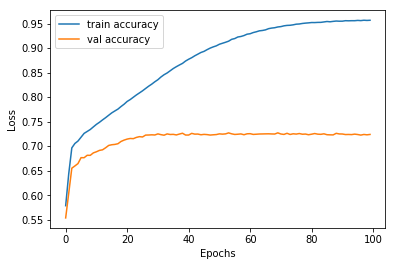

In [46]:
import matplotlib.pyplot as plt
plt.plot(r.history['acc'], label = 'train accuracy')
plt.plot(r.history['val_acc'], label = 'val accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

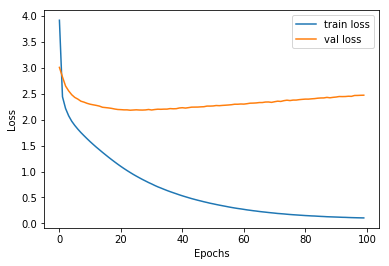

In [47]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [48]:
#During prediction, use the decoder to output the hidden state.
encoder_prediction_model = Model(inputs = [encoder_input], outputs = [h_encoder, c_encoder])

In [49]:
#Once we get the hidden state, pass it to the decoder that along the decoder input will output word indexes.
input_decoder2 = Input([1, ])
input_h = Input([LATENT_DIM, ])
input_c = Input([LATENT_DIM, ])
embedded_decoder_input2 = decoder_embeddings(input_decoder2)
o2, h2, c2 = decoder_lstm(embedded_decoder_input2, initial_state=[input_h, input_c])
outputs2 = dense(o2)
decoder_prediction_model = Model(inputs = [input_decoder2, input_h, input_c], outputs = [outputs2, h2, c2])

In [50]:
#Sample sentence.
def sample_sentence(encoder_sentence):
    encoder_sequence = encoder_tokenizer.texts_to_sequences([encoder_sentence])
    encoder_sequence_padded = pad_sequences(encoder_sequence, maxlen = MAX_ENCODER_LENGTH, padding = "post")
    h_s, c_s = encoder_prediction_model.predict(np.array(encoder_sequence_padded))
    decoder_input_init = np.array([[decoder_tokenizer.word_index['<sos>']]])
    
    decoder_input_ = decoder_input_init
    decoder_sentence = []
    #Use a loop to feed the decoder input with the last decoder output.
    for i in range(MAX_SEQUENCE_LENGTH):
        probs, h_s, c_s = decoder_prediction_model.predict([decoder_input_, h_s, c_s])
        #Do not take into account the first column.
        word_idx = np.argmax(probs[0, 0, 1:]) + 1
        word = decoder_index2word[word_idx]
        #If end of sentence token, break;
        if word == '<eos>':
            break;
        
        decoder_input_[0, 0] = word_idx;
        decoder_sentence.append(word)
    return ' '.join(decoder_sentence);

In [53]:
n_examples = 10
for i in range(n_examples):
    sample_index = np.random.choice(len(encoder_sentences));
    print("English sentence:", encoder_sentences[sample_index], 
          "\nSpanish translation:", sample_sentence(encoder_sentences[sample_index]))
    print()

English sentence: Who is this boy? 
Spanish translation: ¿quién es un mentiroso.

English sentence: I like old cars. 
Spanish translation: me gusta el pollo.

English sentence: Stay still. 
Spanish translation: no te muevas.

English sentence: He had a stroke. 
Spanish translation: él tuvo un golpe.

English sentence: Why is this? 
Spanish translation: ¿a qué viene esto?

English sentence: Sit down! 
Spanish translation: ¡sentate!

English sentence: Tom drove fast. 
Spanish translation: tom condujo rápido.

English sentence: Let's go by bus. 
Spanish translation: vuelve con coche.

English sentence: Let's do it! 
Spanish translation: ¡hagámoslo!

English sentence: Stuff happens. 
Spanish translation: las cosas pasan.

